In [122]:
import numpy as np
import time
import pickle as pk
from numba import cuda
import json
import math
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.animation as animation

# Gerênciando propriedades constantes

In [123]:
Db = 5e-6
Dn = 5e-6
phi = 0.2
cb = 0.15
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
Cn_max = 0.5e-7
X_nb = 1e-3
central_ini_cond = 0.5
ini_cond_var = 0.1

# Serializing json
constant_properties = json.dumps(
    {
        "Db": Db,
        "Dn": Dn,
        "phi": phi,
        "cb": cb,
        "lambd_nb": lambd_nb,
        "mi_n": mi_n,
        "lambd_bn": lambd_bn,
        "y_n": y_n,
        "Cn_max": Cn_max,
        "X_nb": X_nb,
        "central_ini_cond": central_ini_cond,
        "ini_cond_var": ini_cond_var,
    },
    indent=4,
)

# Writing to sample.json
with open("control_dicts/constant_properties.json", "w") as outfile:
    outfile.write(constant_properties)

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]
ini_cond_var = constant_properties["ini_cond_var"]

# Gerenciando propriedades de malha

In [124]:
h = 0.05
k = 0.0001
x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)
np.random.seed(int(time.time()))
center = (np.random.rand(), np.random.rand())

radius = np.random.rand() * (0.2 - 0.1) + 0.1

# Serializing json
mesh_properties = json.dumps(
    {
        "h": h,
        "k": k,
        "x_dom": x_dom,
        "y_dom": y_dom,
        "t_dom": t_dom,
        "center": center,
        "radius": radius,
    },
    indent=4,
)

# Writing to sample.json
with open("control_dicts/mesh_properties.json", "w") as outfile:
    outfile.write(mesh_properties)

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

# Inicializando variáveis

In [125]:
def preencher_matriz_radialmente(tam_max):
    # Cria uma matriz de zeros com as dimensões fornecidas
    matriz = np.zeros((tam_max, tam_max), dtype=int)

    radius = 3
    cx, cy = (tam_max // 2, tam_max // 2)

    for i in range(tam_max):
        for j in range(tam_max):
            # Calculate distance from center to each point
            if (i - cx) ** 2 + (j - cy) ** 2 <= radius**2:
                matriz[i, j] = 1  # Set point inside the circle to 1

    return matriz


def preencher_matriz_randomicamente(linhas, colunas):
    # Cria uma matriz de zeros com as dimensões fornecidas
    matriz = np.zeros((linhas, colunas), dtype=int)

    # Calcula o número total de elementos a serem preenchidos com 1
    total_elementos = linhas * colunas
    elementos_para_preencher = int(0.08 * total_elementos)

    # Gera índices aleatórios únicos para preenchimento
    np.random.seed(42)

    indices = np.random.choice(total_elementos, elementos_para_preencher, replace=False)

    # Converte os índices lineares em índices matriciais
    for index in indices:
        i, j = divmod(index, colunas)
        matriz[i, j] = 1

    return matriz


def init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    central_ini_cond,
    ini_cond_var,
    create_source=True,
    source_type="central",
):
    struct_name = (
        "h--"
        + str(h)
        + "__k--"
        + str(k)
        + "__x_dom_min--"
        + str(x_dom[0])
        + "__x_dom_max--"
        + str(x_dom[-1])
        + "__y_dom_min--"
        + str(y_dom[0])
        + "__y_dom_max--"
        + str(y_dom[-1])
        + "__t_dom_min--"
        + str(t_dom[0])
        + "__t_dom_max--"
        + str(t_dom[-1])
        + "__center--"
        + str(center)
        + "__radius--"
        + str(radius)
    )

    print("struct_name: ", struct_name)

    size_x = int(((x_dom[1] - x_dom[0]) / (h)) + 1)
    size_y = int(((y_dom[1] - y_dom[0]) / (h)) + 1)
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    initial_cond = np.linspace(
        central_ini_cond * (1 - ini_cond_var),
        central_ini_cond * (1 + ini_cond_var),
        num=size_t,
        endpoint=True,
    )

    if create_source:
        if source_type == "central":
            leu_source_points = preencher_matriz_radialmente(size_x)
        elif source_type == "random":
            leu_source_points = preencher_matriz_randomicamente(size_x, size_x)
        else:
            print("Not implemented type")
            return
        
        with open("source_points/lymph_vessels.pkl", "wb") as f:
            pk.dump(leu_source_points, f)

    else:
        with open("source_points/lymph_vessels.pkl", "rb") as f:
            leu_source_points = pk.load(f)

    print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

    print(
        "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
            size_t,
            size_x,
            size_y,
        )
    )

    return (size_x, size_y, size_t, initial_cond, leu_source_points, struct_name)

# Versão Serial

In [126]:
# Função que descreve a taxa de variação da concentração de bactérias (Cb)
def fb(Cb, Cn, i, j, cb, lambd_nb):
    # O crescimento de bactérias é reduzido pela presença de neutrófilos (Cn)
    # por um fator lambd_nb
    return (cb - lambd_nb * Cn[i, j]) * Cb[i, j]


# Função que descreve a taxa de variação da concentração de neutrófilos (Cn)
def fn(Cb, Cn, source_points, i, j, y_n, Cn_max, lambd_bn, mi_n):
    # Crescimento dos neutrófilos depende da presença de bactérias (Cb)
    # Também considera uma taxa de decaimento natural (mi_n) e a interação com
    # bactérias (lambd_bn)
    return (
        y_n * Cb[i, j] * (Cn_max - Cn[i, j]) * source_points[i, j]
        - lambd_bn * Cn[i, j] * Cb[i, j]
        - mi_n * Cn[i, j]
    )


# Função para aplicar condições iniciais à concentração de bactérias (Cb)
def apply_initial_conditions(ini_cond, Cb, cx, cy, radius, tam_max):
    for i in range(tam_max):
        for j in range(tam_max):
            # Calculate distance from center to each point
            if (i - cx) ** 2 + (j - cy) ** 2 <= radius**2:
                Cb[i][j] = ini_cond  # Set point inside the circle to 1

    return Cb


# Função principal para resolver as equações diferenciais parciais usando diferenças finitas
def solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    initial_cond,
    center,
    radius,
    verbose=False,
):

    # Inicializando as matrizes para concentrações de neutrófilos (Cn) e bactérias (Cb)
    Cn_new = np.zeros((size_x, size_y))
    Cb_new = np.zeros((size_x, size_y))

    # Matrizes para armazenar as concentrações em cada passo de tempo
    Cn_final = np.zeros((size_t, size_x, size_y))
    Cb_final = np.zeros((size_t, size_x, size_y))

    # Aplicando condições iniciais para a concentração de bactérias
    cx_real, cy_real = center
    cx_disc = cx_real / h
    cy_disc = cy_real / h
    radius_disc = radius / h

    Cb_new = apply_initial_conditions(
        initial_cond, Cb_new, cx_disc, cy_disc, radius_disc, size_x
    )

    # Armazenando as condições iniciais
    Cb_final[0] = Cb_new
    Cn_final[0] = Cn_new

    # Loop sobre o tempo
    for time in range(1, size_t):
        # Atualizando as concentrações anteriores (passo temporal anterior)
        Cn_old = Cn_new.copy()
        Cb_old = Cb_new.copy()

        global_max_v = 0

        # Loop sobre o espaço (malha espacial)
        for i in range(size_x):

            for j in range(size_y):

                diff_Cb_right = (
                    0 if (i == size_x - 1) else (Cb_old[i + 1, j] - Cb_old[i, j])
                )

                diff_Cb_left = 0 if (i == 0) else (Cb_old[i, j] - Cb_old[i - 1, j])

                diff_Cb_up = (
                    0 if (j == size_y - 1) else (Cb_old[i, j + 1] - Cb_old[i, j])
                )

                diff_Cb_down = 0 if (j == 0) else (Cb_old[i, j] - Cb_old[i, j - 1])

                max_vx = np.max(
                    (
                        abs(diff_Cb_left * X_nb / h),
                        abs(diff_Cb_right * X_nb / h),
                    )
                )

                max_vy = np.max(
                    (
                        abs(diff_Cb_down * X_nb / h),
                        abs(diff_Cb_up * X_nb / h),
                    )
                )

                max_v = max(max_vx, max_vy)

                if max_v > global_max_v:
                    global_max_v = max_v

                # Atualizando as concentrações de bactérias
                Cb_new[i][j] = (
                    (k * Db)
                    / (h * h * phi)
                    * (diff_Cb_right - diff_Cb_left + diff_Cb_up - diff_Cb_down)
                    + (k / phi) * fb(Cb_old, Cn_old, i, j, cb, lambd_nb)
                    + Cb_old[i, j]
                )

                diff_Cn_right = (
                    0 if i == size_x - 1 else ((Cn_old[i + 1, j] - Cn_old[i, j]))
                )

                diff_Cn_left = 0 if i == 0 else ((Cn_old[i, j] - Cn_old[i - 1, j]))

                diff_Cn_up = (
                    0 if j == size_y - 1 else ((Cn_old[i, j + 1] - Cn_old[i, j]))
                )

                diff_Cn_down = 0 if j == 0 else ((Cn_old[i, j] - Cn_old[i, j - 1]))

                adv_right = (
                    0
                    if i == size_x - 1
                    else (
                        (Cn_old[i, j] * diff_Cb_right)
                        if diff_Cb_right > 0
                        else (Cn_old[i + 1, j] * diff_Cb_right)
                    )
                )

                adv_left = (
                    0
                    if i == 0
                    else (
                        (Cn_old[i, j] * diff_Cb_left)
                        if diff_Cb_left < 0
                        else (Cn_old[i - 1, j] * diff_Cb_left)
                    )
                )

                adv_up = (
                    0
                    if j == size_y - 1
                    else (
                        (Cn_old[i, j] * diff_Cb_up)
                        if diff_Cb_up > 0
                        else (Cn_old[i, j + 1] * diff_Cb_up)
                    )
                )

                adv_down = (
                    0
                    if j == 0
                    else (
                        (Cn_old[i, j] * diff_Cb_down)
                        if diff_Cb_down < 0
                        else (Cn_old[i, j - 1] * diff_Cb_down)
                    )
                )

                # Atualizando as concentrações de neutrófilos
                Cn_new[i][j] = (
                    (k * Dn)
                    / (h * h * phi)
                    * (diff_Cn_right - diff_Cn_left + diff_Cn_up - diff_Cn_down)
                    - (X_nb * k)
                    / (h * h * phi)
                    * (adv_right - adv_left + adv_up - adv_down)
                    + (k / phi)
                    * fn(
                        Cb_old,
                        Cn_old,
                        leu_source_points,
                        i,
                        j,
                        y_n,
                        Cn_max,
                        lambd_bn,
                        mi_n,
                    )
                    + Cn_old[i, j]
                )

                # Armazenando os resultados para o passo de tempo atual
                Cb_final[time][i][j] = Cb_new[i][j]
                Cn_final[time][i][j] = Cn_new[i][j]

        # Calcula critério de CFL

        cfl_adv = global_max_v * k / h

        cfl_dif = np.max((4 * Db * k / (h * h), 4 * Dn * k / (h * h)))

        if cfl_adv > 1:
            print(
                "ERROR - CFL criterium not matched on iteration {} for advection: {}".format(
                    time, cfl_adv
                )
            )
            break
        elif cfl_dif > 1:
            print(
                "ERROR - CFL criterium not matched on iteration {} for difusion: {}".format(
                    time, cfl_dif
                )
            )
            break

        else:
            if (time % (size_t // 10) == 0 or time == 0) and verbose:
                print(
                    "CFL criterium on iteration {}: {}".format(
                        time, max(cfl_adv, cfl_dif)
                    )
                )

    # Retornando as matrizes finais de concentração de bactérias e neutrófilos ao
    # longo do tempo
    return Cb_final, Cn_final

## Fonte central

In [127]:
size_x, size_y, size_t, initial_cond, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    central_ini_cond,
    ini_cond_var,
    create_source=True,
    source_type="central"
)

print(leu_source_points)

struct_name:  h--0.05__k--0.0001__x_dom_min--0__x_dom_max--1__y_dom_min--0__y_dom_max--1__t_dom_min--0__t_dom_max--10__center--(0.996597957717456, 0.7968640025110959)__radius--0.13097810518729616
Size x = 21, y = 21 
 
Steps in time = 100001
Steps in space_x = 21
Steps in space_y = 21

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [128]:
start = time.time()

Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=True
)

end = time.time()

serial_time = end - start

with open("fvm_sim/Cp__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cb, f)

with open("fvm_sim/Cl__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cn, f)

CFL criterium on iteration 10000: 4.149959873651299e-05
CFL criterium on iteration 20000: 8.612631317541608e-05
CFL criterium on iteration 30000: 0.00017876271420526086
CFL criterium on iteration 40000: 0.0003710818774258732
CFL criterium on iteration 50000: 0.0007704007642776386
CFL criterium on iteration 60000: 0.0015996320396106203
CFL criterium on iteration 70000: 0.0033218654344100416
CFL criterium on iteration 80000: 0.006899291678101687
CFL criterium on iteration 90000: 0.014331423857012106
CFL criterium on iteration 100000: 0.029774072428880957


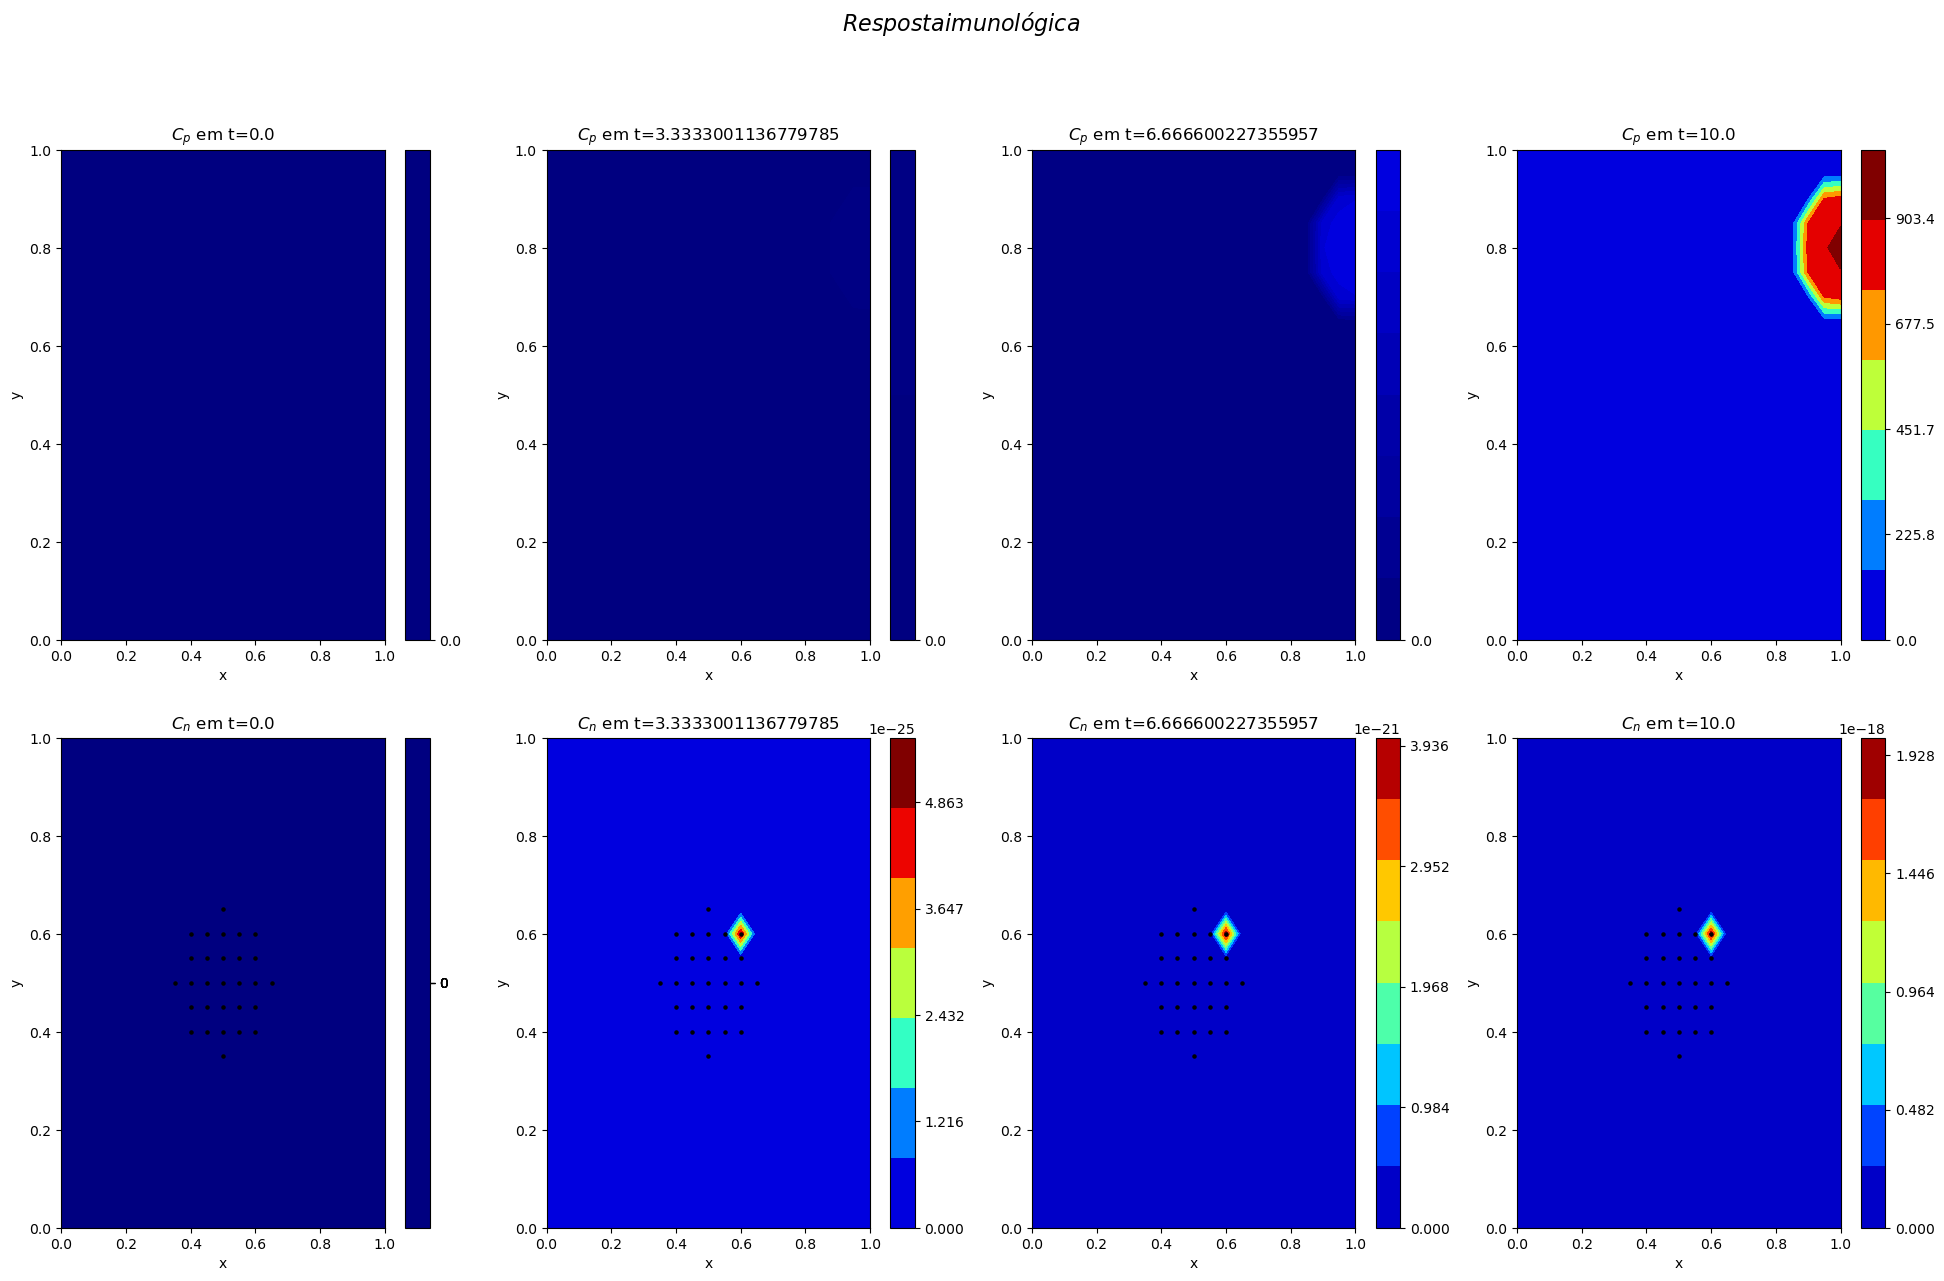

In [129]:
import matplotlib.pyplot as plt


t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)


Y, X = np.meshgrid(
    x_np,
    y_np,
)

source_index = np.argwhere(leu_source_points == 1)
source_points = np.zeros(source_index.shape)

for i in range(len(source_points)):
    source_points[i, 0] = x_np[source_index[i,0]]
    source_points[i, 1] = y_np[source_index[i,1]]

time_plot = np.linspace(0, size_t-1, num=4, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("$Resposta imunológica$", fontsize=16)


for i, time_inst in enumerate(time_plot):

    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cb)
    vmax = np.max(Cb)

    contour = ax.contourf(
        X,
        Y,
        Cb[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_p$ em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) * 1 + 1)

    vmin = np.min(Cn[time_inst])
    vmax = np.max(Cn[time_inst])

    contour = ax.contourf(
        X,
        Y,
        Cn[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.scatter(source_points[:, 0], source_points[:, 1], color='k', s=5)

    ax.set_title("$C_n$ em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

## Fontes aleatórias

In [130]:
size_x, size_y, size_t, initial_cond, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    central_ini_cond,
    ini_cond_var,
    create_source=True,
    source_type="random"
)

print(leu_source_points)

struct_name:  h--0.05__k--0.0001__x_dom_min--0__x_dom_max--1__y_dom_min--0__y_dom_max--1__t_dom_min--0__t_dom_max--10__center--(0.996597957717456, 0.7968640025110959)__radius--0.13097810518729616
Size x = 21, y = 21 
 
Steps in time = 100001
Steps in space_x = 21
Steps in space_y = 21

[[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [131]:
start = time.time()

Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=True
)

end = time.time()

serial_time = end - start

with open("fvm_sim/Cp__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cb, f)

with open("fvm_sim/Cl__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cn, f)

CFL criterium on iteration 10000: 4.149959873647311e-05
CFL criterium on iteration 20000: 8.612631317444846e-05
CFL criterium on iteration 30000: 0.00017876271419740855
CFL criterium on iteration 40000: 0.00037108187738388456
CFL criterium on iteration 50000: 0.00077040076409596
CFL criterium on iteration 60000: 0.0015996320389208972
CFL criterium on iteration 70000: 0.0033218654320201334
CFL criterium on iteration 80000: 0.00689929167036481
CFL criterium on iteration 90000: 0.014331423833250275
CFL criterium on iteration 100000: 0.02977407235890191


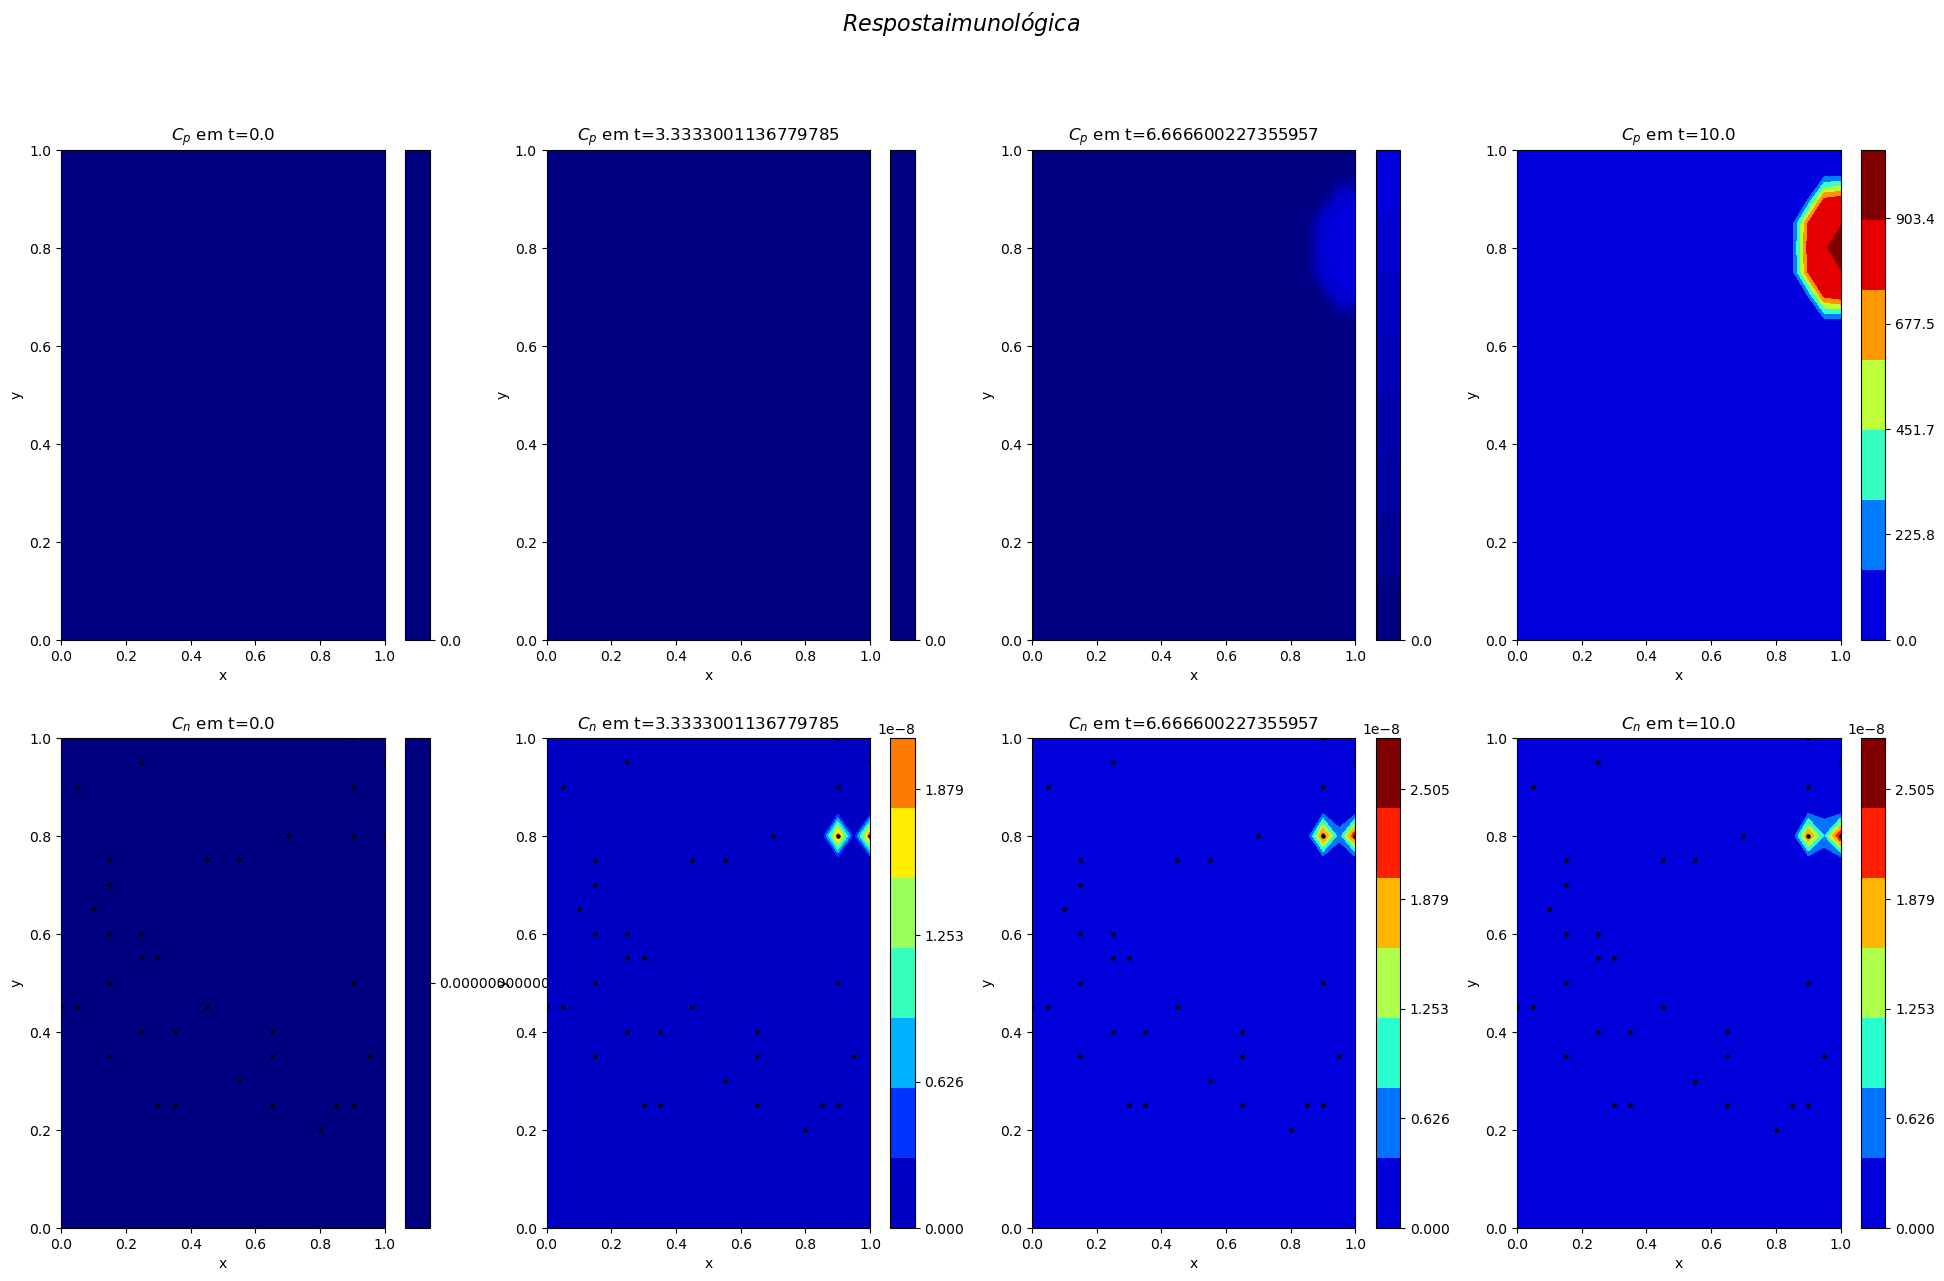

In [132]:
import matplotlib.pyplot as plt


t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)


Y, X = np.meshgrid(
    x_np,
    y_np,
)

source_index = np.argwhere(leu_source_points == 1)
source_points = np.zeros(source_index.shape)

for i in range(len(source_points)):
    source_points[i, 0] = x_np[source_index[i,0]]
    source_points[i, 1] = y_np[source_index[i,1]]

time_plot = np.linspace(0, size_t-1, num=4, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("$Resposta imunológica$", fontsize=16)


for i, time_inst in enumerate(time_plot):

    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cb)
    vmax = np.max(Cb)

    contour = ax.contourf(
        X,
        Y,
        Cb[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_p$ em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) * 1 + 1)

    vmin = np.min(Cn)
    vmax = np.max(Cn)

    contour = ax.contourf(
        X,
        Y,
        Cn[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.scatter(source_points[:, 0], source_points[:, 1], color='k', s=5)

    ax.set_title("$C_n$ em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

# Versão paralela

In [133]:
# Função que descreve a taxa de variação da concentração de bactérias (Cb)
@cuda.jit(device=True)
def cu_fb(Cb, Cn, i, j, cb, lambd_nb):
    # O crescimento de bactérias é reduzido pela presença de neutrófilos (Cn)
    # por um fator lambd_nb
    return (cb - lambd_nb * Cn[i, j]) * Cb[i, j]


# Função que descreve a taxa de variação da concentração de neutrófilos (Cn)
@cuda.jit(device=True)
def cu_fn(Cb, Cn, source_points, i, j, y_n, Cn_max, lambd_bn, mi_n):
    # Crescimento dos neutrófilos depende da presença de bactérias (Cb)
    # Também considera uma taxa de decaimento natural (mi_n) e a interação com
    # bactérias (lambd_bn)
    return (
        y_n * Cb[i, j] * (Cn_max - Cn[i, j]) * source_points[i, j]
        - lambd_bn * Cn[i, j] * Cb[i, j]
        - mi_n * Cn[i, j]
    )


# Função para aplicar condições iniciais à concentração de bactérias (Cb)
@cuda.jit(device=True)
def cu_apply_initial_conditions(ini_cond, Cb, cx, cy, radius, tam_max):
    for i in range(tam_max):
        for j in range(tam_max):
            # Calculate distance from center to each point
            if (i - cx) ** 2 + (j - cy) ** 2 <= radius**2:
                Cb[i][j] = ini_cond  # Set point inside the circle to 1

    return Cb


# Função principal para resolver as equações diferenciais parciais usando diferenças finitas
@cuda.jit()
def cu_solve_pde(
    Cb_buf_0,
    Cn_buf_0,
    Cb_buf_1,
    Cn_buf_1,
    Cb_final,
    Cn_final,
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    initial_cond,
    center,
    radius,
):

    # Domain position
    i, j = cuda.grid(2)

    # Aplicando condições iniciais para a concentração de bactérias
    cx_real, cy_real = center
    cx_disc = cx_real / h
    cy_disc = cy_real / h
    radius_disc = radius / h

    # Aplicando condições iniciais para a concentração de bactérias
    Cb_buf_0 = cu_apply_initial_conditions(
        initial_cond, Cb_buf_0, cx_disc, cy_disc, radius_disc, size_x
    )

    # Armazenando as condições iniciais
    Cb_final[0][i, j] = Cb_buf_0[i, j]
    Cn_final[0][i, j] = Cn_buf_0[i, j]

    # Don't continue if our index is outside the domain

    if i >= size_x or j >= size_y:
        return

    # Prepare to do a grid-wide synchronization later

    grid = cuda.cg.this_grid()

    # Loop sobre o tempo
    for time in range(1, size_t):
        # Atualizando as concentrações anteriores (passo temporal anterior)

        if (time % 2) == 0:

            Cn_old = Cn_buf_1
            Cb_old = Cb_buf_1

            Cn_new = Cn_buf_0
            Cb_new = Cb_buf_0

        else:
            Cn_old = Cn_buf_0
            Cb_old = Cb_buf_0

            Cn_new = Cn_buf_1
            Cb_new = Cb_buf_1

        diff_Cb_right = 0 if (i == size_x - 1) else (Cb_old[i + 1, j] - Cb_old[i, j])

        diff_Cb_left = 0 if (i == 0) else (Cb_old[i, j] - Cb_old[i - 1, j])

        diff_Cb_up = 0 if (j == size_y - 1) else (Cb_old[i, j + 1] - Cb_old[i, j])

        diff_Cb_down = 0 if (j == 0) else (Cb_old[i, j] - Cb_old[i, j - 1])

        # Atualizando as concentrações de bactérias
        Cb_new[i][j] = (
            (k * Db)
            / (h * h * phi)
            * (diff_Cb_right - diff_Cb_left + diff_Cb_up - diff_Cb_down)
            + (k / phi) * cu_fb(Cb_old, Cn_old, i, j, cb, lambd_nb)
            + Cb_old[i, j]
        )

        diff_Cn_right = 0 if i == size_x - 1 else ((Cn_old[i + 1, j] - Cn_old[i, j]))

        diff_Cn_left = 0 if i == 0 else ((Cn_old[i, j] - Cn_old[i - 1, j]))

        diff_Cn_up = 0 if j == size_y - 1 else ((Cn_old[i, j + 1] - Cn_old[i, j]))

        diff_Cn_down = 0 if j == 0 else ((Cn_old[i, j] - Cn_old[i, j - 1]))

        adv_right = (
            0
            if i == size_x - 1
            else (
                (Cn_old[i, j] * diff_Cb_right)
                if diff_Cb_right > 0
                else (Cn_old[i + 1, j] * diff_Cb_right)
            )
        )

        adv_left = (
            0
            if i == 0
            else (
                (Cn_old[i, j] * diff_Cb_left)
                if diff_Cb_left < 0
                else (Cn_old[i - 1, j] * diff_Cb_left)
            )
        )

        adv_up = (
            0
            if j == size_y - 1
            else (
                (Cn_old[i, j] * diff_Cb_up)
                if diff_Cb_up > 0
                else (Cn_old[i, j + 1] * diff_Cb_up)
            )
        )

        adv_down = (
            0
            if j == 0
            else (
                (Cn_old[i, j] * diff_Cb_down)
                if diff_Cb_down < 0
                else (Cn_old[i, j - 1] * diff_Cb_down)
            )
        )

        # Atualizando as concentrações de neutrófilos
        Cn_new[i][j] = (
            (k * Dn)
            / (h * h * phi)
            * (diff_Cn_right - diff_Cn_left + diff_Cn_up - diff_Cn_down)
            - (X_nb * k) / (h * h * phi) * (adv_right - adv_left + adv_up - adv_down)
            + (k / phi)
            * cu_fn(
                Cb_old, Cn_old, leu_source_points, i, j, y_n, Cn_max, lambd_bn, mi_n
            )
            + Cn_old[i, j]
        )

        # Armazenando os resultados para o passo de tempo atual
        Cb_final[time][i][j] = Cb_new[i][j]
        Cn_final[time][i][j] = Cn_new[i][j]

        grid.sync()

# Comparação entre versões

In [134]:
# from fvm_model_parallel import cu_solve_pde
# from fvm_model_parallel import cu_solve_pde

start = time.time()

# Definindo número de threads e blocos para cuda

threadsperblock = (size_x, size_y)
blockspergrid_x = math.ceil(size_x / threadsperblock[0])
blockspergrid_y = math.ceil(size_y / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Inicializando as matrizes para concentrações de neutrófilos (Cn) e bactérias (Cb)

Cb_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))
Cn_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))

# Initializing matrix for leukocytes source (Cn)

device_leu_source = cuda.to_device(leu_source_points)

# This extra array is used for synchronization purposes

Cb_buf_1 = cuda.device_array_like(Cb_buf_0)
Cn_buf_1 = cuda.device_array_like(Cn_buf_0)

# Matrizes para armazenar as concentrações em cada passo de tempo
Cb_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))
Cn_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))

cu_solve_pde[threadsperblock, blockspergrid](
    Cb_buf_0,
    Cn_buf_0,
    Cb_buf_1,
    Cn_buf_1,
    Cb_final_device,
    Cn_final_device,
    device_leu_source,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    center,
    radius,
)

Cb_host = np.empty(shape=Cb_final_device.shape, dtype=Cb_final_device.dtype)
Cb_final_device.copy_to_host(Cb_host)

Cn_host = np.empty(shape=Cn_final_device.shape, dtype=Cn_final_device.dtype)
Cn_final_device.copy_to_host(Cn_host)

end = time.time()

cuda_time = end - start

speed_up = serial_time / cuda_time

print(
    "Serial time: {}s\n".format(serial_time),
    "Parallel time: {}s\n".format(cuda_time),
    "Speed-up: {}\n".format(speed_up),
)

TypeError: Signature mismatch: 24 argument types given, but function takes 25 arguments